In [1]:
!pip install -q -q -q Cython

In [142]:
%matplotlib inline

In [143]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [144]:
import numpy as np
import pandas as pd

from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
from matplotlib import cm

In [145]:
%%cython


import numpy as np
cimport numpy as cnp
import cython
cnp.import_array()
@cython.boundscheck(False)
@cython.wraparound(False)

def convofc(cnp.ndarray[long, ndim=1] I, 
            cnp.ndarray[long, ndim=1] J, 
            cnp.ndarray[double, ndim=1] W, 
            cnp.ndarray[double, ndim=2] kernel, 
            cnp.ndarray[double, ndim=2, mode='c'] resf):
    cdef:
        ssize_t ki, kj,i, j, ii, jj, si, sj, kki, kkj

    

    ki = int(np.floor(kernel.shape[0]/2))
    kj = int(np.floor(kernel.shape[1]/2))
    si = int(resf.shape[0])
    sj = int(resf.shape[1])
    kki = int(kernel.shape[0])
    kkj = int(kernel.shape[1])

    for n in range(len(I)):
        for i in range(kki):
            ii = int(i - ki + I[n])
            if (ii>=0) & (ii<(si)):
                
                for j in range(kkj):
                
                    jj = int(j - kj + J[n])
                    if (jj>=0) & (jj<sj):
                        
                        resf[ii,jj] = resf[ii, jj] + kernel[i,j] * W[n]
    return(resf)


In [146]:
def build_kernel(r,size):
    XY = np.linspace(-0.5,0.5,size)
    X, Y = np.meshgrid(XY, XY,  indexing='ij')
    kernel = X**2 + Y**2 
    kernel = (1- (kernel/(r**2)))**2 * (kernel<=(r)**2)
    kernel = kernel 
    return(kernel[kernel.sum(1)>0][:,kernel.sum(1)>0])

In [147]:
def cpc(rs, sigma=0.5, granularity=5):
    step = np.min(rs)/granularity
    size = np.ceil((1/step)).astype(int)
    resf = np.zeros((size,size))

    N = rng.poisson(-np.log(rs)).astype(int) * 100
    Xy = rng.uniform(size=(np.sum(N),2))
    W = rng.normal(size=np.sum(N), scale=sigma, loc = -.5 * sigma**2)
    rsN = np.repeat(rs,N).reshape(np.sum(N),)

    I = np.floor(Xy[:, 0] / step).astype(int)
    J = np.floor(Xy[:, 1] / step).astype(int)
    
    for r in rs:
        kernel = build_kernel(r, size)
        resf = convofc(I[rsN==r], J[rsN==r], W[rsN==r], kernel.astype(float), resf.astype(float))
    resf = np.exp(resf)/np.sum(np.exp(resf))
    return(resf)

### Exemples coumpund poisson cascade

In [148]:
test = cpc(rs, sigma=0.01, granularity=1)

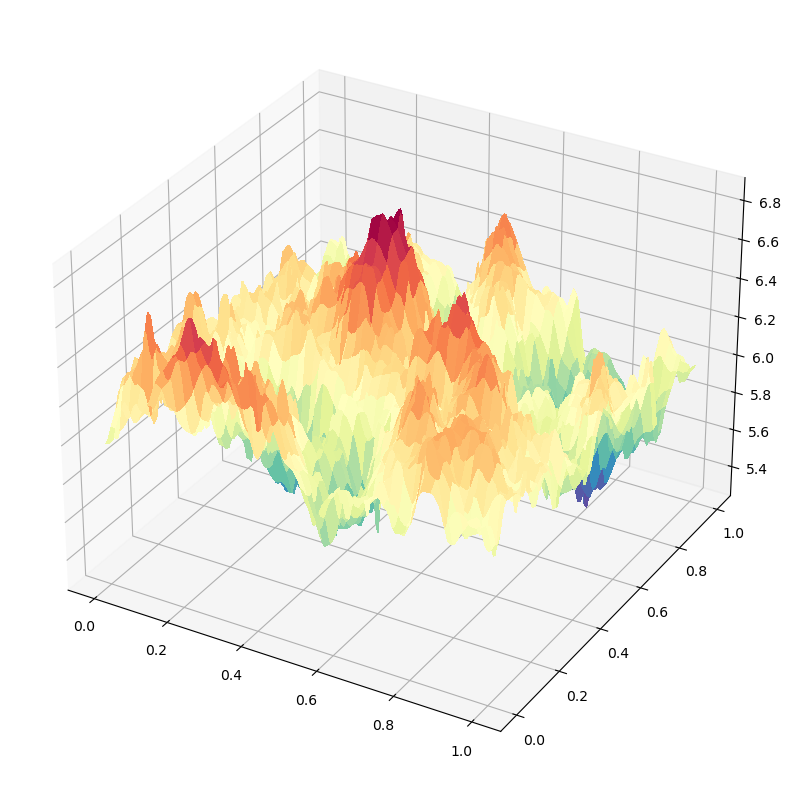

In [150]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

X, Y = np.meshgrid(np.linspace(0,1,test.shape[0]), np.linspace(0,1,test.shape[0]))
surf = ax.plot_surface(X,Y, test, cmap=cm.Spectral_r,
                       linewidth=0, antialiased=False)

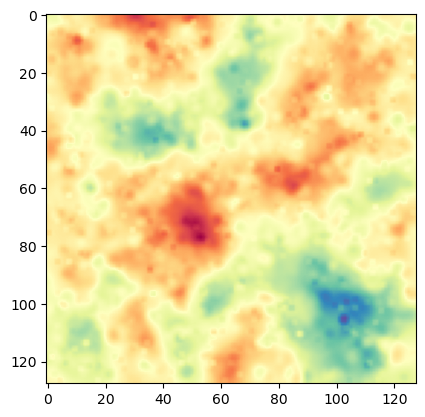

In [151]:
plt.imshow(test, cmap=cm.Spectral_r)

### Joint cpc

In [165]:
def jcpc(rs, sigma1=0.05, sigma2=0.05, l=0.5, granularity=2):
    step = np.min(rs)/granularity
    size = np.ceil((1/step)).astype(int)
    resf1 = np.zeros((size,size))
    resf2 = np.zeros((size,size))
           
    N = rng.poisson(-np.log(rs)* 50).astype(int) 
    Xy = rng.uniform(size=(np.sum(N),2))
    
    W = rng.multivariate_normal(np.array([0,0]),
                          np.array([[sigma1**2,l*sigma1*sigma2],
                                  [l*sigma1*sigma2, sigma2**2]]), np.sum(N))
    
    rsN = np.repeat(rs,N).reshape(np.sum(N),)
    
    I = np.floor(Xy[:, 0] / step).astype(int)
    J = np.floor(Xy[:, 1] / step).astype(int)
    
    for r in rs:
        kernel = build_kernel(r, size)
        resf1 = convofc(I[rsN==r], J[rsN==r], W[rsN==r,0], kernel.astype(float), resf1.astype(float))
        resf2 = convofc(I[rsN==r], J[rsN==r], W[rsN==r,1], kernel.astype(float), resf2.astype(float))
        
    return(np.stack((np.exp(resf1), np.exp(resf2)), axis=-1))

In [166]:
rs = (0.5**0.25)**np.arange(1,25)
rs

array([0.84089642, 0.70710678, 0.59460356, 0.5       , 0.42044821,
       0.35355339, 0.29730178, 0.25      , 0.2102241 , 0.1767767 ,
       0.14865089, 0.125     , 0.10511205, 0.08838835, 0.07432544,
       0.0625    , 0.05255603, 0.04419417, 0.03716272, 0.03125   ,
       0.02627801, 0.02209709, 0.01858136, 0.015625  ])

In [167]:
test = np.stack([jcpc(rs, l =l, sigma1=.3, sigma2=.3) for l in np.arange(-1,1.1,0.1)])

In [168]:
np.savez_compressed('test_fractal.npz', test)

In [63]:
N = rng.poisson(-np.log(rs)*100).astype(int)
N

array([418])

In [119]:
rs

array([0.25      , 0.1767767 , 0.125     , 0.08838835, 0.0625    ,
       0.04419417, 0.03125   , 0.02209709, 0.015625  , 0.01104854])

In [76]:
temp[:,:,1] * temp[:,:,0]

array([[1.        , 1.        , 1.        , ..., 0.99999997, 0.99999997,
        0.99999997],
       [1.        , 1.        , 1.        , ..., 0.99999997, 0.99999997,
        0.99999997],
       [0.99999999, 0.99999999, 0.99999999, ..., 0.99999997, 0.99999997,
        0.99999997],
       ...,
       [1.        , 1.        , 1.        , ..., 1.00000002, 1.00000002,
        1.00000002],
       [1.        , 0.99999999, 1.        , ..., 1.00000002, 1.00000001,
        1.00000002],
       [0.99999999, 0.99999999, 0.99999999, ..., 1.00000001, 1.00000001,
        1.00000001]])

In [74]:
sigma1=0.1
sigma2=0.1
l = -1
N=100
W = rng.multivariate_normal(np.array([0,0]),
                          np.array([[sigma1**2,l*sigma1*sigma2],
                                  [l*sigma1*sigma2, sigma2**2]]), np.sum(N))
    

In [75]:
W

array([[-0.05962001,  0.05962001],
       [ 0.13074417, -0.13074417],
       [-0.06743026,  0.06743026],
       [ 0.23660129, -0.23660129],
       [-0.08819724,  0.08819723],
       [ 0.12960628, -0.12960629],
       [-0.16509338,  0.16509338],
       [ 0.00257305, -0.00257305],
       [ 0.15306912, -0.15306913],
       [-0.00624993,  0.00624994],
       [-0.04571052,  0.04571052],
       [ 0.28576961, -0.28576961],
       [-0.00391389,  0.00391389],
       [-0.12825609,  0.1282561 ],
       [-0.13736712,  0.13736712],
       [-0.0410041 ,  0.0410041 ],
       [-0.08671497,  0.08671497],
       [ 0.05525843, -0.05525843],
       [-0.09468397,  0.09468397],
       [-0.03257669,  0.03257669],
       [ 0.06567684, -0.06567684],
       [-0.02102228,  0.02102228],
       [ 0.16096285, -0.16096285],
       [-0.13728259,  0.13728259],
       [ 0.09646965, -0.09646965],
       [ 0.0351275 , -0.0351275 ],
       [-0.00843713,  0.00843713],
       [ 0.06125812, -0.06125812],
       [ 0.12201046,